<h1 style="text-align: center;">Projet CLIP</h1>

# Installations & Préparation

In [ ]:
import os
if os.path.exists('/content/gdrive/My Drive'):
    print("Drive déjà monté")
else:
    from google.colab import drive
    drive.mount('/content/gdrive')

In [3]:
import sys
my_local_drive='/content/gdrive/My Drive/Colab Notebooks/projectCLIP'

if not os.path.exists(my_local_drive):
    os.makedirs(my_local_drive)

sys.path.append(my_local_drive)
%cd $my_local_drive

/content/gdrive/My Drive/Colab Notebooks/projectCLIP


## Bibliothèque

In [ ]:
import os
import pandas as pd
import re
import numpy as np
import random
import zipfile
import requests
import io
import math
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.utils import register_keras_serializable
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from tensorflow.keras.metrics import Mean
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder

# Pour utiliser au mieux le GPU
AUTOTUNE = tf.data.AUTOTUNE

In [5]:
url = "https://www.lirmm.fr/~poncelet/Ressources/flickr_subset2.zip"
target_dir = "flickr_subset2"

# Vérifie si le dossier existe déjà
if os.path.exists(target_dir) and os.path.isdir(target_dir):
    print("Données déjà disponibles dans :", target_dir)
else:
    print("Téléchargement de flickr_subset2.zip...")
    response = requests.get(url)
    if response.status_code == 200:
        print("Téléchargement réussi. Extraction...")
        with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
            # Extraire sans ajouter de sous-dossier supplémentaire
            for member in zip_ref.namelist():
                # Corrige les chemins pour ignorer un éventuel prefixe flickr_subset2/
                member_path = member
                if member.startswith("flickr_subset2/"):
                    member_path = member[len("flickr_subset2/"):]
                target_path = os.path.join(target_dir, member_path)

                # Si c'est un répertoire, on le crée
                if member.endswith("/"):
                    os.makedirs(target_path, exist_ok=True)
                else:
                    os.makedirs(os.path.dirname(target_path), exist_ok=True)
                    with zip_ref.open(member) as source, open(target_path, "wb") as target:
                        target.write(source.read())
        print(f"Données extraites dans : {target_dir}")
    else:
        print("Échec du téléchargement. Code HTTP :", response.status_code)


Téléchargement de flickr_subset2.zip...
Téléchargement réussi. Extraction...
Données extraites dans : flickr_subset2


## Fonctions et Classes utiles

In [31]:
# FONCTIONS UTILES

def preview_images_from_dir(image_dir, image_size=(224, 224), n=12,
                            subset="training", seed=123):
    """
    Affiche n images avec leurs labels à partir d'un dossier
    (flow_from_directory).
    N'utilise PAS train_gen pour ne pas en avancer l'index.
    """
    # Générateur léger juste pour l'aperçu
    # Ici il y a une bonne indication si vous regardez bien pour la classif :)
    preview_datagen = ImageDataGenerator(validation_split=0.2, rescale=1./255)

    preview_gen = preview_datagen.flow_from_directory(
        image_dir,
        target_size=image_size,
        batch_size=n,
        class_mode="categorical",
        subset=subset,
        shuffle=True,
        seed=seed
    )

    imgs, y = next(preview_gen)    # imgs: (n, H, W, 3), y: one-hot
    class_names = list(preview_gen.class_indices.keys())
    labels = np.argmax(y, axis=1)

    rows = 3
    cols = int(np.ceil(n / rows))
    plt.figure(figsize=(4*cols, 4*rows))
    for i in range(min(n, imgs.shape[0])):
        plt.subplot(rows, cols, i+1)
        plt.imshow(imgs[i])
        plt.title(class_names[labels[i]])
        plt.axis("off")
    plt.tight_layout()
    plt.show()


def preview_images_from_gen(gen):
    plt.figure(figsize=(12, 8))
    images, labels = next(gen)

    for i in range(min(9, len(images))):
        plt.subplot(3, 3, i+1)
        if images.shape[-1] == 1:  # Grayscale
            plt.imshow(images[i].squeeze(), cmap='gray')
        else:  # RGB
            plt.imshow(images[i])
        plt.title(f"Classe: {np.argmax(labels[i])}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def plot_history_simple(history):
    """
    Trace côte à côte les courbes Loss et Accuracy (train/val si dispo)
    à partir d'un objet Keras History.
    """
    hist = history.history

    # compatibilité anciennes versions ("acc"/"val_acc")
    acc_key = "accuracy" if "accuracy" in hist else "acc"
    val_acc_key = "val_accuracy" if "val_accuracy" in hist else "val_acc"

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # --- Loss ---
    if "loss" in hist:
        axes[0].plot(hist["loss"], label="train")
    if "val_loss" in hist:
        axes[0].plot(hist["val_loss"], label="val")
    axes[0].set_title("Loss")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].legend()

    # --- Accuracy ---
    if acc_key in hist:
        axes[1].plot(hist[acc_key], label="train")
        if val_acc_key in hist:
            axes[1].plot(hist[val_acc_key], label="val")
        axes[1].set_title("Accuracy")
        axes[1].set_xlabel("Epoch")
        axes[1].set_ylabel("Accuracy")
        axes[1].legend()
    else:
        axes[1].set_visible(False)  # si pas d'accuracy, on masque le 2e plot

    plt.tight_layout()
    plt.show()

In [7]:
# Classes à utiliser pour la partie classification de texte. Laquelle ?
@register_keras_serializable()
class SelectFirstToken (layers.Layer):
  # Retourne le premier mot
    def call(self, inputs):
        return inputs[:, 0] # (batch, embed_dim)

@register_keras_serializable()
class SelectMean(layers.Layer):
  # Retourne la moyenne des mots - bien si pas trop de PAD - chaînes même taille
    def call(self, inputs):
        # inputs: (batch, seq_len, embed_dim)
        return tf.reduce_mean(inputs, axis=1)  # (batch, embed_dim)


@register_keras_serializable()
class MaskedMean(layers.Layer):
  # Retourne la moyenne des mots sans être trop influencé par PAD
    def call(self, inputs):
        seq_out, token_ids = inputs   # (B,L,D), (B,L)
        mask = tf.cast(tf.not_equal(token_ids, 0), seq_out.dtype)  # PAD=0
        mask = tf.expand_dims(mask, -1)        # (B,L,1)
        summed = tf.reduce_sum(seq_out * mask, axis=1)             # (B,D)
        counts = tf.reduce_sum(mask, axis=1)                        # (B,1)
        return summed / tf.maximum(counts, 1.0)


# Classe utile pour la partie Clip mais il fallait bien regarder pour la trouver
@register_keras_serializable()
class L2Normalize(layers.Layer):
    def __init__(self, axis=-1, **kwargs):
        super().__init__(**kwargs)
        self.axis = axis

    def call(self, inputs):
        return tf.math.l2_normalize(inputs, axis=self.axis)

    def get_config(self):
        config = super().get_config()
        config.update({"axis": self.axis})
        return config

# PARTIE SMALL_BERT = COPIE DU NOTEBOOK
# ============================
# PositionalEmbedding Layer
# ============================
@tf.keras.utils.register_keras_serializable()
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(input_dim=vocab_size,
                                                 output_dim=embed_dim)
        self.position_embeddings = layers.Embedding(input_dim=sequence_length,
                                                    output_dim=embed_dim)
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(0, length)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.not_equal(inputs, 0)

    def get_config(self):
        config = super().get_config()
        config.update({
            "sequence_length": self.sequence_length,
            "vocab_size": self.vocab_size,
            "embed_dim": self.embed_dim,
        })
        return config

# ============================
# TransformerBlock
# ============================
@tf.keras.utils.register_keras_serializable()
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads,ff_dim, dropout_rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.supports_masking = True
        self.att = layers.MultiHeadAttention(num_heads=num_heads,
                                             key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(dropout_rate)
        self.dropout2 = layers.Dropout(dropout_rate)

    def call(self, inputs, training=False, mask=None):
        seq_len = tf.shape(inputs)[1]
        attn_mask = None
        if mask is not None:
            attn_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.float32)
            attn_mask = tf.tile(attn_mask, [1, seq_len, 1])

        attn_output = self.att(inputs, inputs, inputs, attention_mask=attn_mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

        def get_config(self):
            config = super().get_config()
            config.update({
                "embed_dim": self.att.key_dim,
                "num_heads": self.att.num_heads,
                "ff_dim": self.ffn.layers[0].units,
                "dropout_rate": self.dropout1.rate,
            })
            return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)


# ============================
# SmallBERT encoder
# ============================
@register_keras_serializable()
class SmallBERT(tf.keras.Model):
    def __init__(self, sequence_length, vocab_size, embed_dim, num_heads,
                 ff_dim, num_layers, **kwargs):
        super().__init__(**kwargs)
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.num_layers = num_layers

        self.pos_embedding = PositionalEmbedding(sequence_length, vocab_size,
                                                 embed_dim)

        self.transformer_blocks = [
            TransformerBlock(embed_dim,
                             num_heads, ff_dim) for _ in range(num_layers)
        ]
        self.layernorm = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout = tf.keras.layers.Dropout(0.1)

    def call(self, inputs, training=False):
        x = self.pos_embedding(inputs)
        for block in self.transformer_blocks:
            x = block(x, training=training)
        x = self.layernorm(x)
        return self.dropout(x, training=training)

    def get_config(self):
        config = super().get_config()
        config.update({
            "sequence_length": self.sequence_length,
            "vocab_size": self.vocab_size,
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "ff_dim": self.ff_dim,
            "num_layers": self.num_layers,
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)


Quelques variables qui peuvent être utiles pour le projet. Ces variables ont été définies pour l'apprentissage d'un modèle Clip réalisé avec les mêmes données. Elles devraient vous être utiles pour vos modèles. **Il est conseillé de conserver le nom des variables suivantes car nous vous donnerons un peu de code utilisant ces variables pour vous aider**.

In [8]:
# Répertoire cible pour sauvegarder vos modèles
model_dir = "./models_forclip"
os.makedirs(model_dir, exist_ok=True)

# Répertoire des données
dataset_dir = "./flickr_subset2"

# Répertoire des images
image_dir = os.path.join(dataset_dir, "images")
# Répertoire des captions
captions_dir = os.path.join(dataset_dir, "captions")

# Variables utiles
# Attention respecter bien l'ordre alphabétique des classes pour
# le générateur
class_names = ['ball', 'bike', 'dog', 'water']
# Pour les images
image_size=(224, 224)
image_shape = image_size + (3,)

# Pour les textes
sequence_length = 32
vocab_size = 10000
num_heads = 4
ff_dim = 256
num_layers = 2

# Pour les images et les textes dans le modèle CLIP
embed_dim = 128

# Réaliser un classifieur d’images pour les 4 classes

### Images Non-traité

Found 480 images belonging to 4 classes.


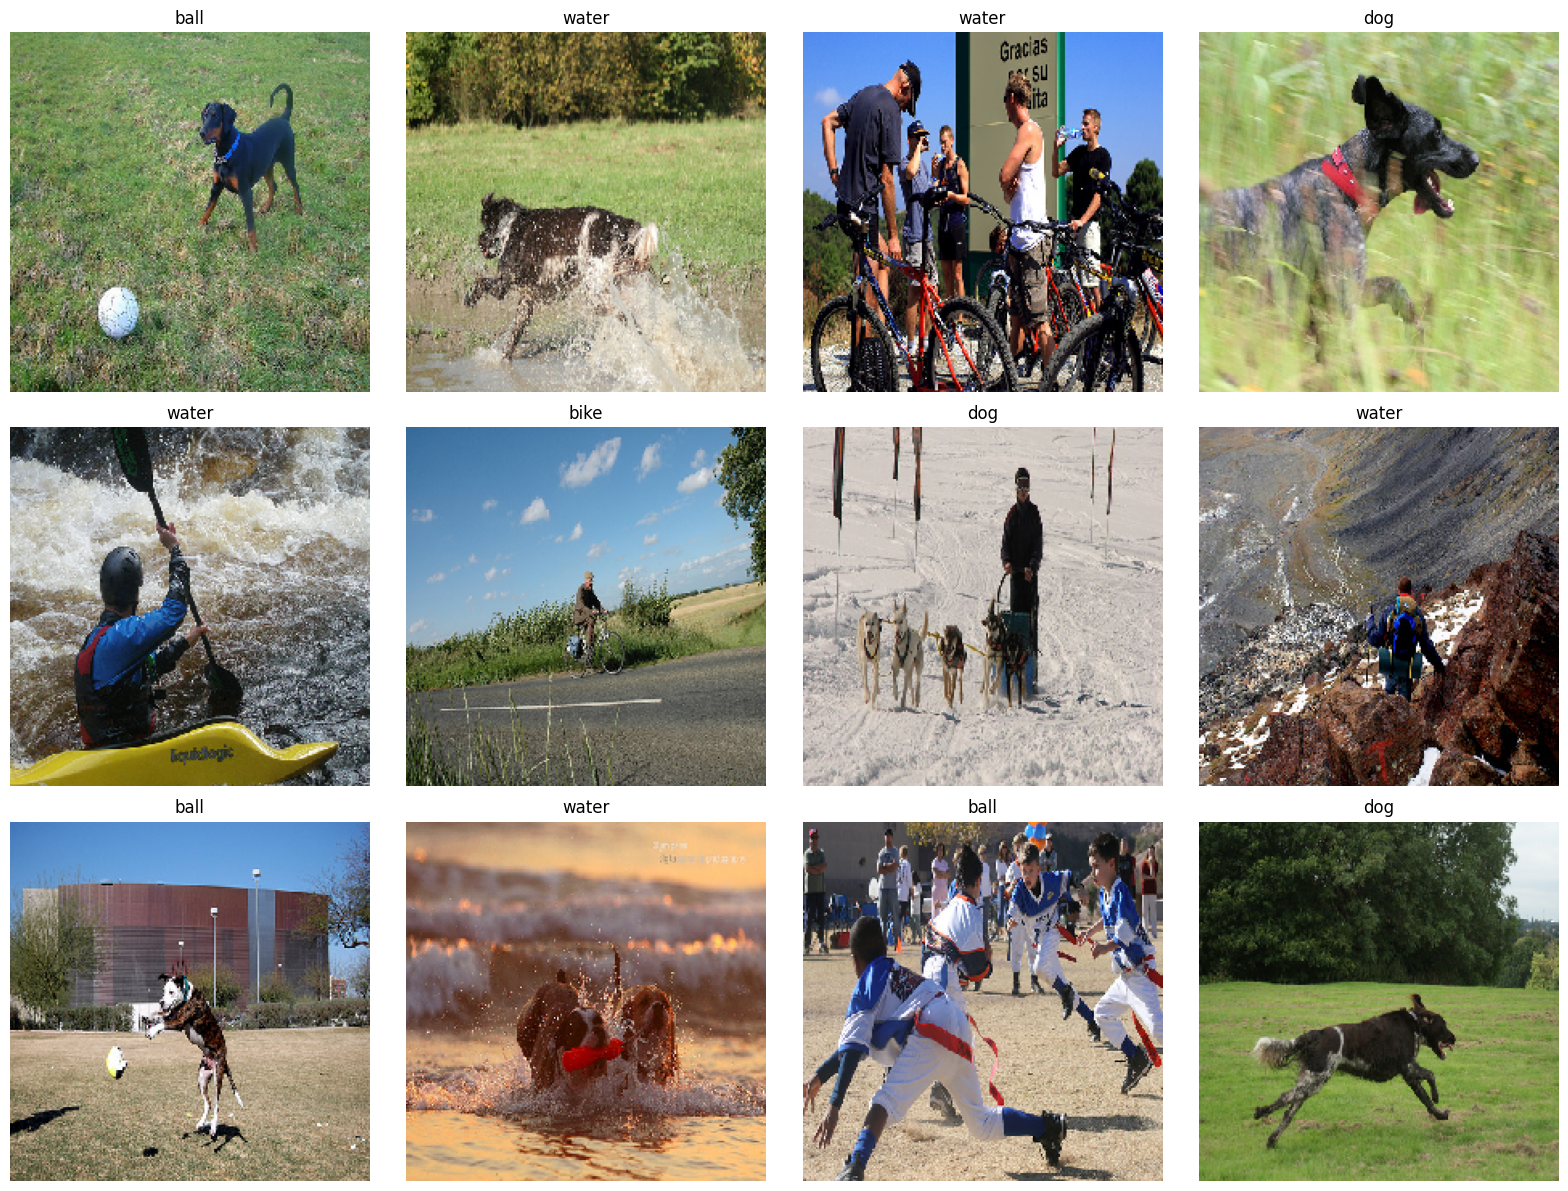

In [9]:
# Affichage des images
preview_images_from_dir(image_dir, image_size=image_size, n=12, subset="training", seed=42)

### Traitement des images

In [134]:
# Variables utiles pour l'entrainement
learning_rate=1e-3
batch_size = 32
epochs = 40

Found 480 images belonging to 4 classes.
Found 120 images belonging to 4 classes.


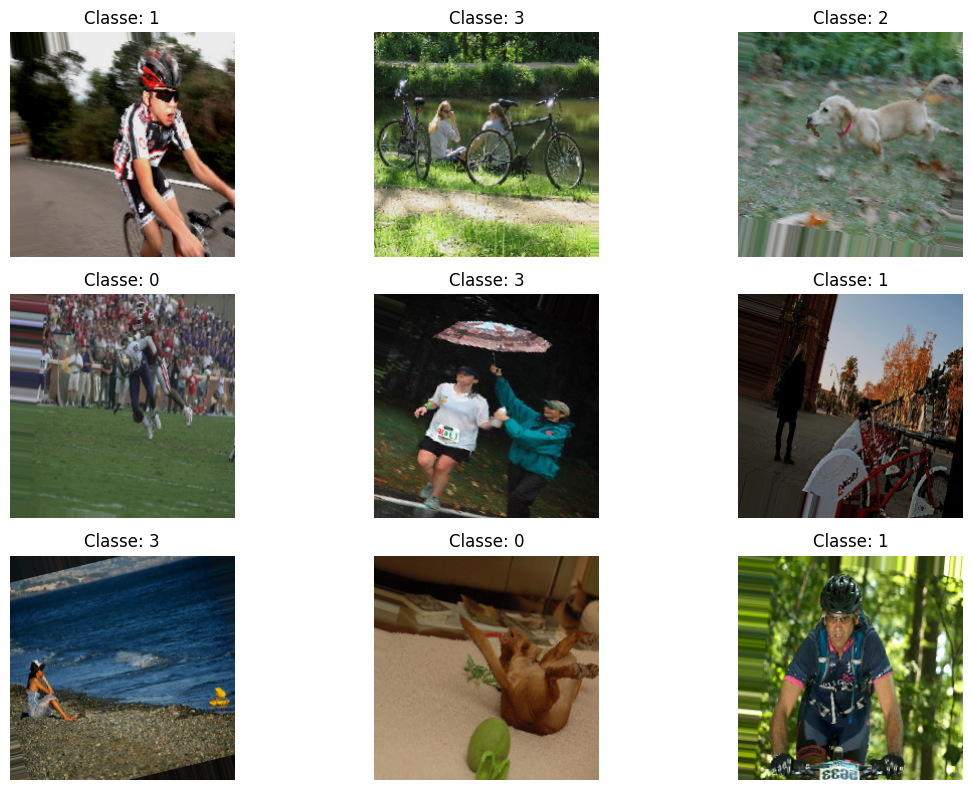


Nombre d'images par classe:
[120 120 120 120]


In [123]:
train_datagen = ImageDataGenerator(
    rescale=1./255,           # Normalisation
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.1,  
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
    brightness_range=(0.8,1.2)
)

train_generator = train_datagen.flow_from_directory(
    image_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    color_mode='rgb'
)

val_generator = train_datagen.flow_from_directory(
    image_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    color_mode='rgb'
)

preview_images_from_gen(train_generator)
print("\nNombre d'images par classe:")
print(np.bincount(train_generator.classes))

### Création du CNN de classification d'image
Ici, nous nous somme inspiré de [geeksforgeeks](https://www.geeksforgeeks.org/machine-learning/image-classifier-using-cnn/)

Pour gérer le over-fitting car notre jeu de données est faible en quantité, on a utilisé les Layers Dropout qui désactive aléatoirement certains neurones. Pour savoir quelle dropout rate et ou placer ces layers, nous nous sommes inspiré de cet [article](https://medium.com/@vishnuam/dropout-in-convolutional-neural-networks-cnn-422a4a17da41)


Nous avons découvert que notre architecture est trop petite, en effet nous passons de 200,704 neurones à 64 neurones. Cest un goulot d'étranglement enorme.
<img src="docs/CNN/structure_CNN_1.png" alt="architecture" width="400"/>

In [ ]:
inputs = Input(shape=image_shape, name="input_layer_image")
x = Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
# x = BatchNormalization()(x)
x = MaxPooling2D(2,2)(x)

x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = Dropout(0.2)(x)
# x = BatchNormalization()(x)
x = MaxPooling2D(2,2)(x)

x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = Dropout(0.25)(x)
# x = BatchNormalization()(x)
x = MaxPooling2D(2,2)(x)

x = Conv2D(256, (3,3), activation='relu', padding='same')(x)
x = Dropout(0.3)(x)
# x = BatchNormalization()(x)
x = MaxPooling2D(2,2)(x)

x = GlobalAveragePooling2D()(x)

x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)

outputs = Dense(len(class_names), activation='softmax', name="output_layer")(x)

model = Model(inputs, outputs, name="CNN_image_class")
model.summary()

# model = Sequential([
#           ...
# ]) N'est pas la solution pour la création futur de CLIP, car elle permet pas la fusion du plusieurs inputs

Model: "CNN_image_class"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_image (InputLayer)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_60 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_60 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_61 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_61 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_62 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_62 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_63 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_63 (MaxPooling2D) │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_15     │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 405,124 (1.55 MB)

 Trainable params: 405,124 (1.55 MB)

 Non-trainable params: 0 (0.00 B)

### Compilation et entrainement du model

In [130]:
model.compile(
    optimizer= Adam(learning_rate=learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

On veut economiser notre temps et ressource donc on va vérifier l'évolution du Loss et si cette métrique ne s'améliore pas, on stop l'entrainement. => Early Stopping

Ensuite on veut itérer les valeurs comme learning_rate, batch_size ou epochs, donc il est important et efficace lorsque l'on reprend le projet de sauvegarder le meilleur model.  => Model Checkpoint

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_cnn_image_class.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

In [135]:
# On a pas besoin de la plus part des parametre ici car train_generator et train_datagen on déja tout spécifier au model fit
history = model.fit(
    train_generator,
    validation_data=val_generator, # Pas besoin de StratifiedKFold car train_datagen fait déja la répartition du travail
    epochs=epochs,
    callbacks=[early_stopping, checkpoint, reduce_lr],
    verbose=1
)

Epoch 1/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.2289 - loss: 1.3974
Epoch 1: val_loss improved from inf to 1.38550, saving model to best_cnn_image_class.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 81s 5s/step - accuracy: 0.2303 - loss: 1.3971 - val_accuracy: 0.2500 - val_loss: 1.3855 - learning_rate: 0.0010
Epoch 2/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.2246 - loss: 1.3884
Epoch 2: val_loss improved from 1.38550 to 1.38137, saving model to best_cnn_image_class.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 76s 5s/step - accuracy: 0.2264 - loss: 1.3882 - val_accuracy: 0.2833 - val_loss: 1.3814 - learning_rate: 0.0010
Epoch 3/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.2415 - loss: 1.3823
Epoch 3: val_loss improved from 1.38137 to 1.37744, saving model to best_cnn_image_class.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 76s 5s/step - accuracy: 0.2441 - loss: 1.3819 - val_accuracy: 0.3167 - val_loss: 1.3774 - learning_rate: 0.0010
Epoch 4/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - ac

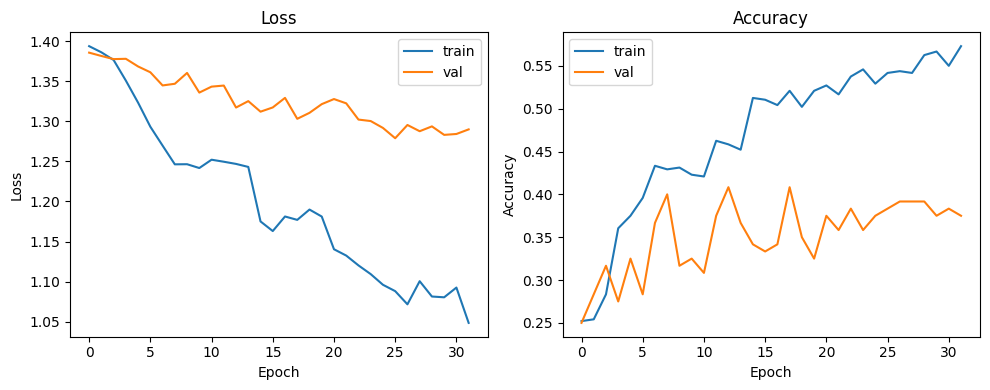

In [137]:
plot_history_simple(history)

### Evaluate the model

In [39]:
best_cnn_model = load_model('best_cnn_image_class.keras')

print("Évaluation finale:")
val_loss, val_acc = best_cnn_model.evaluate(val_generator)

Évaluation finale:
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 621ms/step - accuracy: 0.2221 - loss: 1.3859


# Réaliser un classifieur de textes pour les 4 classes
Le but de cette partie est de créer un classifieur de textes pour les 4 classes du projet. Ce classifieur doit pouvoir attribuer à chaque phrase donnée, une des 4 classes avec lesquelles on travaille.

*Exemple : “pepper the aussi pup” doit se faire attribuer la classe “dog”.*

### Etape 1 : Préparation des données et tokenization

#### Chargement des données + analyse de la structure

In [ ]:
path_csv = os.path.join(dataset_dir, "captions.csv")

df = pd.read_csv(path_csv)

print("Colonnes :", df.columns.tolist())
df.head(-5)

Colonnes : ['image_path', 'label', 'caption']
                   image_path label  \
0      images/dog/dog_001.jpg   dog   
1      images/dog/dog_002.jpg   dog   
2      images/dog/dog_003.jpg   dog   
3      images/dog/dog_004.jpg   dog   
4      images/dog/dog_005.jpg   dog   
..                        ...   ...   
590  images/bike/bike_141.jpg  bike   
591  images/bike/bike_142.jpg  bike   
592  images/bike/bike_143.jpg  bike   
593  images/bike/bike_144.jpg  bike   
594  images/bike/bike_145.jpg  bike   

                                               caption  
0           A black dog and a spotted dog are fighting  
1    A man lays on a bench while his dog sits by him .  
2    A black and white dog is running in a grassy g...  
3    A dog shakes its head near the shore , a red b...  
4                       A black dog leaps over a log .  
..                                                 ...  
590                     A group of bicyclists racing .  
591          A clown with a b

### Tokénization 

In [ ]:
textes = df['caption'].values

vectorizer = TextVectorization(
    max_tokens=vocab_size,
    output_sequence_length=sequence_length
)

# apprentissage du vocabulaire
vectorizer.adapt(textes)
X_text = vectorizer(textes)

y_labels, mapping = pd.factorize(df['label'])
print("ordre des classes :", mapping)

vocab = vectorizer.get_vocabulary()

ordre des classes : Index(['dog', 'water', 'ball', 'bike'], dtype='object')


In [ ]:
#puisqu'on en aura besoin par la suite, c'est plus simple de sauvegardé le vocab appris dans un fichier txt avec 1 mot par ligne

with open('vocab.txt', 'w', encoding='utf-8') as f:
    for word in vocab:
        f.write(f"{word}\n")

print(f"Fichier vocab.txt créé avec {len(vocab)} mots.")

Fichier vocab.txt créé avec 974 mots.


In [ ]:
# vérification que tout va bien 
print("Forme de X, des phrases :", X_text.shape) 
print("Forme de y, des labels :", y_labels.shape) 

Forme de X, des phrases : (600, 32)
Forme de y, des labels : (600,)


### Construction de l'architecture du modèle

In [ ]:
inputs = layers.Input(shape=(sequence_length,), dtype="int32")

# cela transforme nos 32 nombres en 32 vecteurs de taille 128
bert_layer = SmallBERT(sequence_length, vocab_size, embed_dim, num_heads, ff_dim, num_layers)
encoded_seq = bert_layer(inputs)

# on utilise MaskedMean pour transformer les 32 vecteurs en 1 seul qui rep la moyenne (cf. jupyter du prof "classes utiles")
pooled_output = MaskedMean()([encoded_seq, inputs])

# la sortie : un petit réseau qui décide de la catégorie
x = layers.Dense(64, activation="relu")(pooled_output)

# 4 neurones pour les 4 classes
outputs = layers.Dense(4, activation="softmax")(x)

# modèle final
text_model = tf.keras.Model(inputs=inputs, outputs=outputs)
text_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 32)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ small_bert          │ (None, 32, 128)   │  1,944,832 │ input_layer_1[0]… │
│ (SmallBERT)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masked_mean         │ (None, 128)       │          0 │ small_bert[0][0], │
│ (MaskedMean)        │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 64)        │      8,256 │ masked_mean[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 4)         │        260 │ dense_14[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,953,348 (7.45 MB)

 Trainable params: 1,953,348 (7.45 MB)

 Non-trainable params: 0 (0.00 B)

### Compilation du modèle

In [ ]:
text_model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
text_early_stop = EarlyStopping(
    monitor="val_loss",
    patience = 5,
    verbose =1,
    restore_best_weights=True
)

text_checkpoint = ModelCheckpoint(
    "text_model.keras",
    monitor="val_accuracy",
    verbose=1,
    save_best_only=True,
    mode="auto",
    save_freq="epoch"
)

In [ ]:
history = text_model.fit(
    X_text,  # phrases véctorisées
    y_labels, # catégories
    epochs=25,
    batch_size=32,
    validation_split=0.2,
    #callbacks    = [text_checkpoint, text_early_stop]
    
)

Epoch 1/25


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'masked_mean' (of type MaskedMean) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 339ms/step - accuracy: 0.4110 - loss: 1.3094 - val_accuracy: 0.0000e+00 - val_loss: 3.9289
Epoch 2/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 225ms/step - accuracy: 0.7058 - loss: 0.7802 - val_accuracy: 0.1083 - val_loss: 1.9076
Epoch 3/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 218ms/step - accuracy: 0.8735 - loss: 0.3731 - val_accuracy: 0.4000 - val_loss: 1.6490
Epoch 4/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 296ms/step - accuracy: 0.9310 - loss: 0.1894 - val_accuracy: 0.6333 - val_loss: 1.3740
Epoch 5/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 226ms/step - accuracy: 0.9675 - loss: 0.0820 - val_accuracy: 0.6500 - val_loss: 1.3029
Epoch 6/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 223ms/step - accuracy: 0.9641 - loss: 0.1142 - val_accuracy: 0.4333 - val_loss: 2.9206
Epoch 7/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 303ms/step - accuracy: 0.9619 - loss: 0.0923 - val_accuracy: 0.7417 - val_loss: 0.7615
Epoch 8/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 225ms/step - accuracy: 0.9944 - loss: 0.0194 - val_accuracy: 0.5083 -

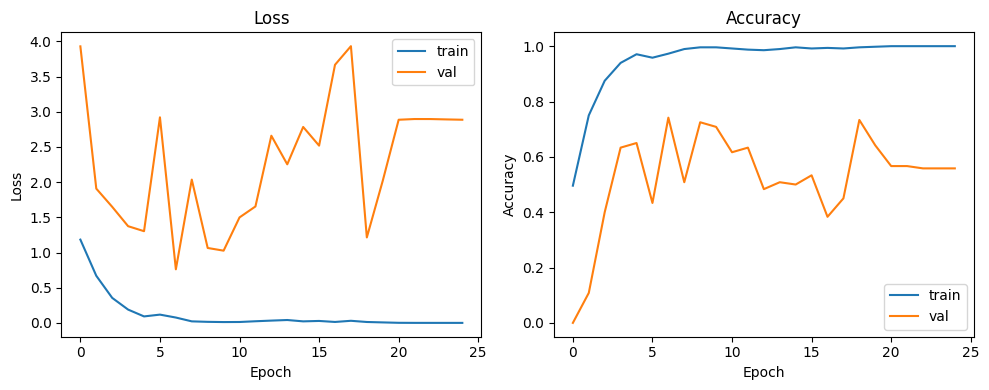

In [ ]:
plot_history_simple(history)